[*********************100%***********************]  1 of 1 completed


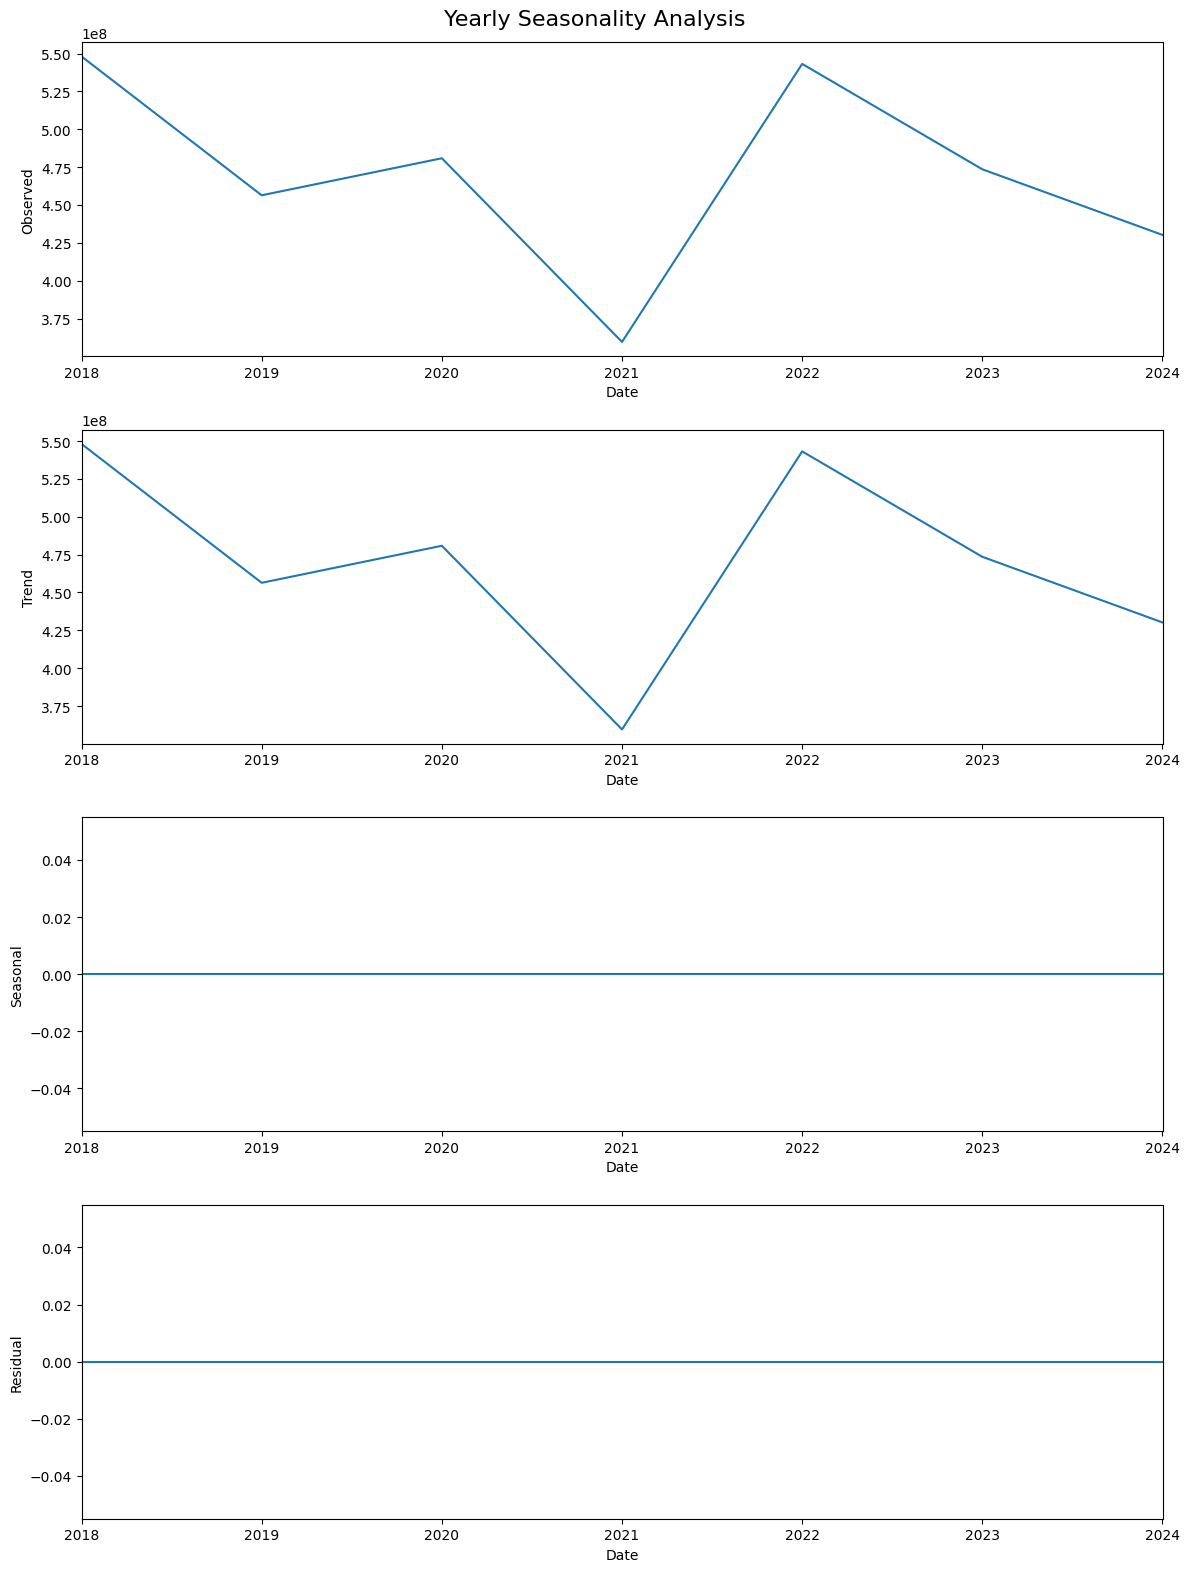

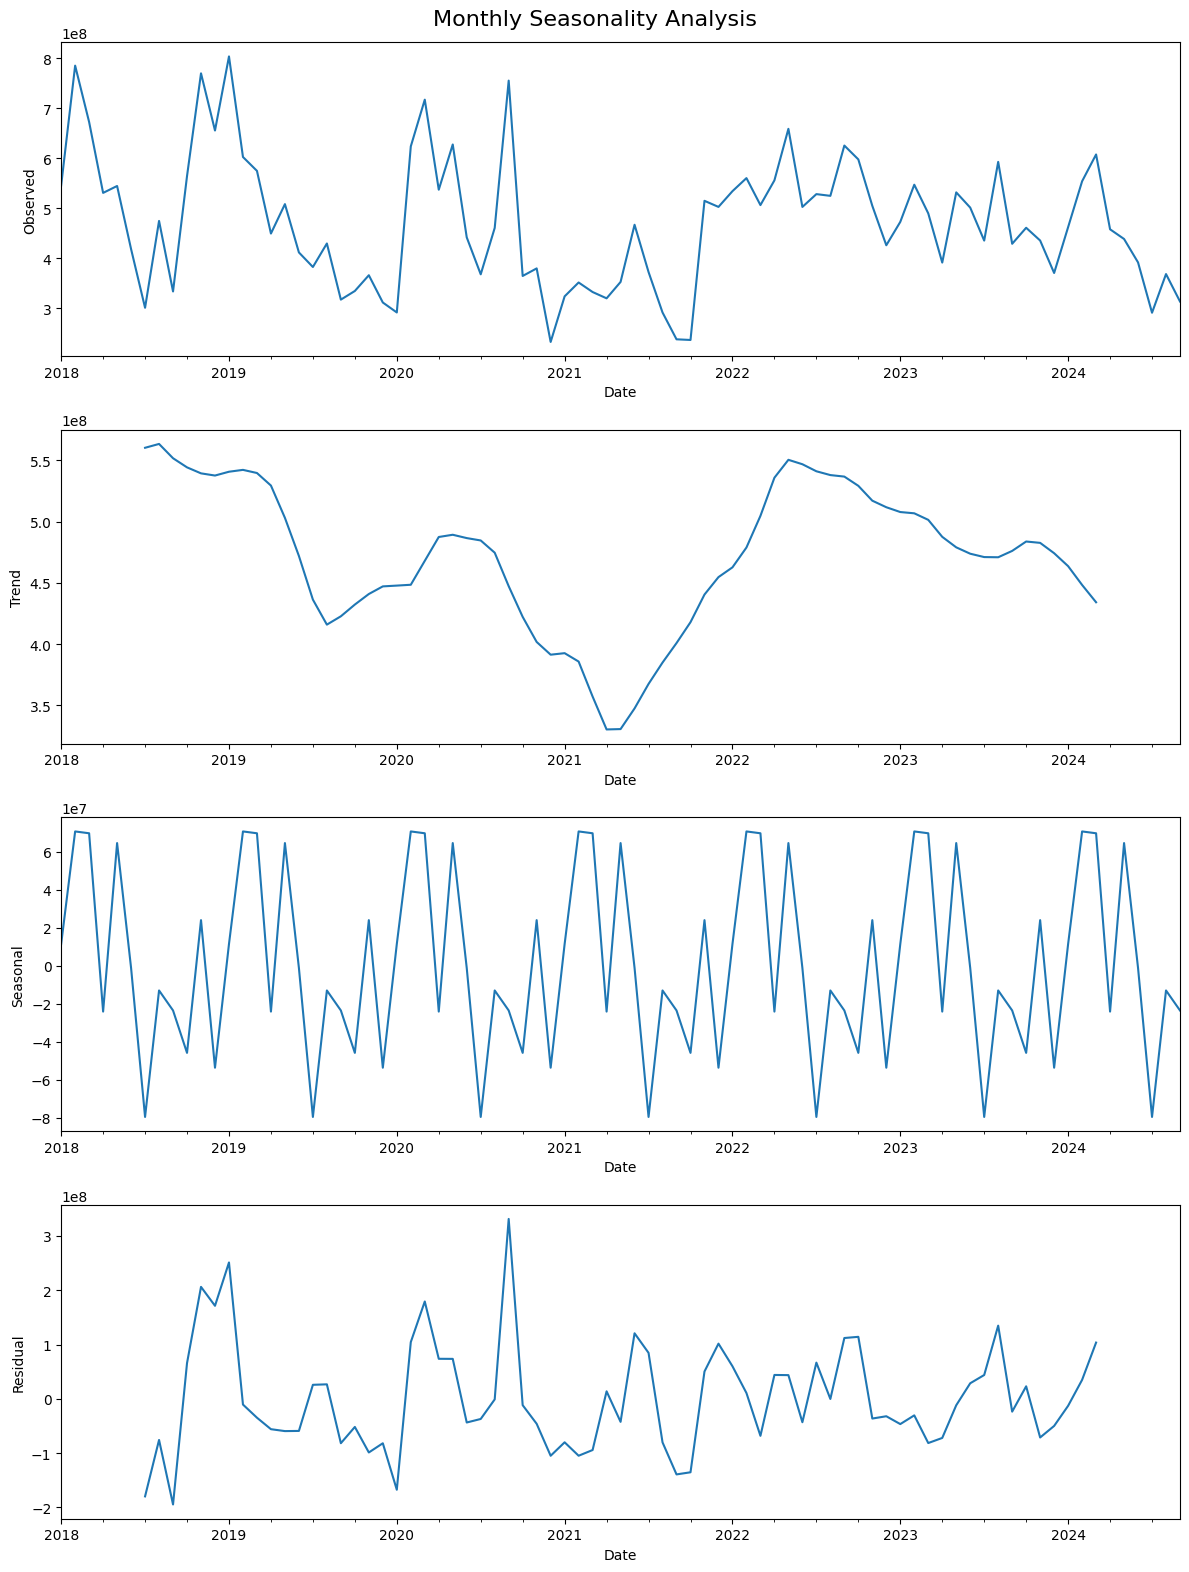

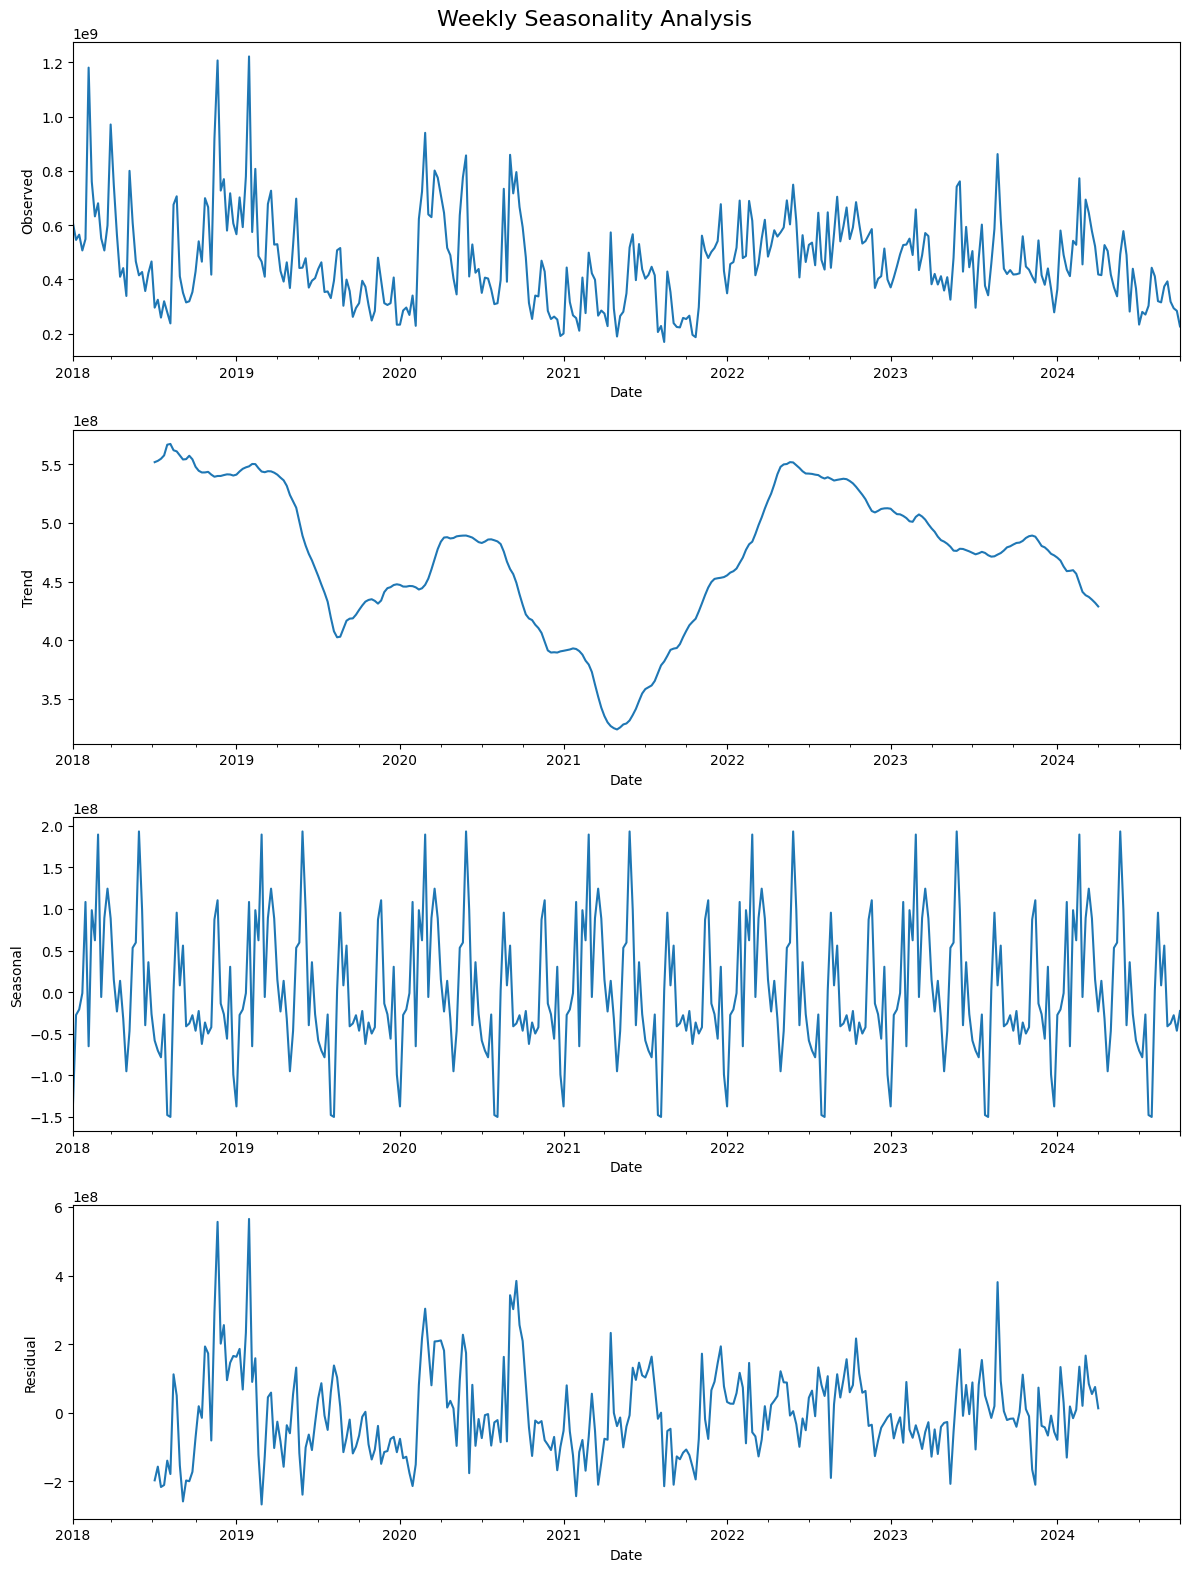

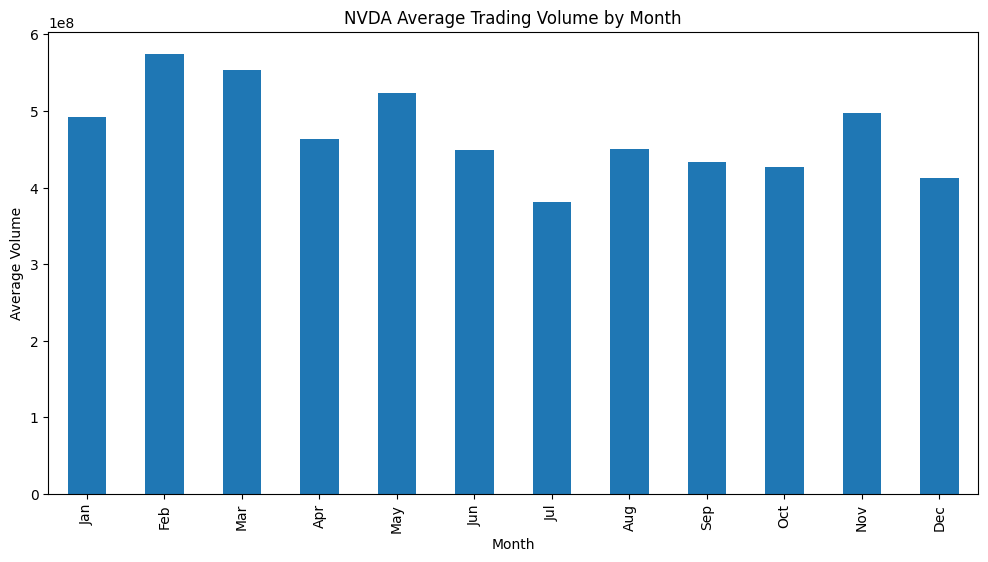

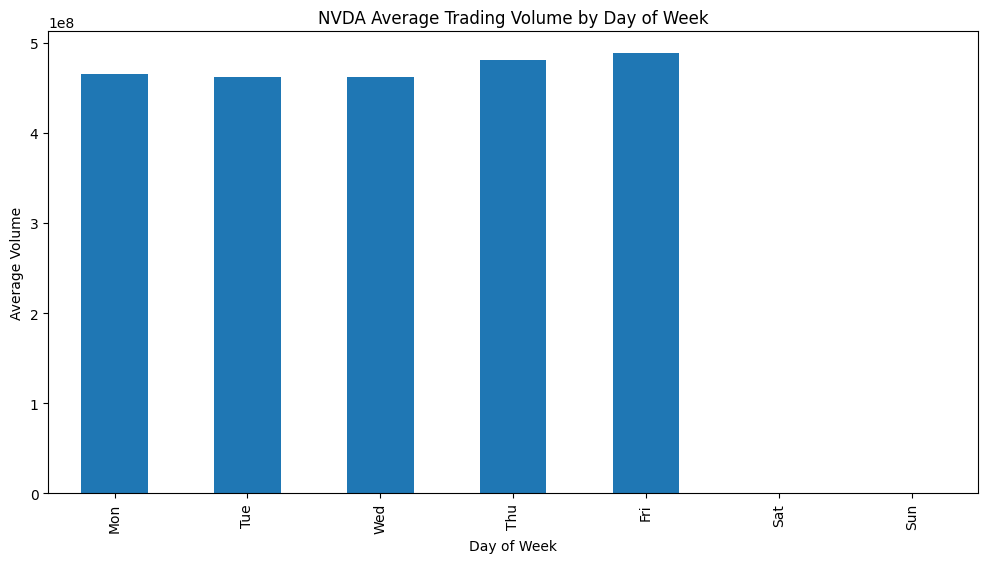

Seasonality analysis complete.


In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Download NVDA data
ticker = "NVDA"
data = yf.download(ticker, start="2018-01-01", end="2024-10-01")

# Resample data to different frequencies
daily_volume = data['Volume']
weekly_volume = daily_volume.resample('W').mean()
monthly_volume = daily_volume.resample('M').mean()
yearly_volume = daily_volume.resample('Y').mean()

# Function to plot seasonal decomposition
def plot_seasonal_decompose(series, title):
    result = seasonal_decompose(series, model='additive')
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))
    fig.suptitle(f'{title} Seasonality Analysis', fontsize=16)
    
    result.observed.plot(ax=ax1)
    ax1.set_ylabel('Observed')
    result.trend.plot(ax=ax2)
    ax2.set_ylabel('Trend')
    result.seasonal.plot(ax=ax3)
    ax3.set_ylabel('Seasonal')
    result.resid.plot(ax=ax4)
    ax4.set_ylabel('Residual')
    
    plt.tight_layout()
    plt.show()

# Yearly seasonality
plot_seasonal_decompose(yearly_volume, 'Yearly')

# Monthly seasonality
plot_seasonal_decompose(monthly_volume, 'Monthly')

# Weekly seasonality
plot_seasonal_decompose(weekly_volume, 'Weekly')

# Calculate average volume by month
monthly_avg = daily_volume.groupby(daily_volume.index.month).mean()
monthly_avg = monthly_avg.reindex(range(1, 13), fill_value=0)

# Plot average volume by month
plt.figure(figsize=(12, 6))
monthly_avg.plot(kind='bar')
plt.title(f'{ticker} Average Trading Volume by Month')
plt.xlabel('Month')
plt.ylabel('Average Volume')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Calculate average volume by day of week
weekday_avg = daily_volume.groupby(daily_volume.index.dayofweek).mean()
weekday_avg = weekday_avg.reindex(range(7), fill_value=0)

# Plot average volume by day of week
plt.figure(figsize=(12, 6))
weekday_avg.plot(kind='bar')
plt.title(f'{ticker} Average Trading Volume by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Volume')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

print("Seasonality analysis complete.")


In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Assuming 'data' is your DataFrame with OHLCV data
# If not, you'll need to load your data here

# Calculate VWAP
data['VWAP'] = (data['Close'] * data['Volume']).cumsum() / data['Volume'].cumsum()

# Create a new column for the anchored VWAP
data['Anchored_VWAP'] = None

# Find all May 1st dates
may_dates = data.index[data.index.month == 5].tolist()

# Calculate anchored VWAP for each period starting from May
for i in range(len(may_dates)):
    start_date = may_dates[i]
    end_date = may_dates[i+1] if i+1 < len(may_dates) else data.index[-1]
    
    period_data = data.loc[start_date:end_date]
    period_vwap = (period_data['Close'] * period_data['Volume']).cumsum() / period_data['Volume'].cumsum()
    
    data.loc[start_date:end_date, 'Anchored_VWAP'] = period_vwap

# Create the candlestick chart with anchored VWAP
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.03, subplot_titles=(f'{ticker} Price', 'Volume'),
                    row_heights=[0.7, 0.3])

# Add candlestick trace
fig.add_trace(go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'],
                name='Price'),
                row=1, col=1)

# Add anchored VWAP trace
fig.add_trace(go.Scatter(x=data.index, y=data['Anchored_VWAP'],
                         mode='lines', name='Anchored VWAP',
                         line=dict(color='purple', width=1)),
                row=1, col=1)

# Add volume bar chart
fig.add_trace(go.Bar(x=data.index, y=data['Volume'], name='Volume'),
              row=2, col=1)

# Update layout
fig.update_layout(
    title=f'{ticker} Price with Anchored VWAP',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,
    height=800,
    showlegend=False
)

# Show the plot
fig.show()


In [10]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

# Assuming 'data' is your DataFrame with OHLCV data and datetime index

# Identify the anchor dates (end of May, November, and February)
data['Year'] = data.index.year
data['Month'] = data.index.month

anchor_months = [2, 5, 11]  # February, May, November
anchor_dates = []

for y in data['Year'].unique():
    for m in anchor_months:
        month_data = data[(data['Year'] == y) & (data['Month'] == m)]
        if not month_data.empty:
            last_date = month_data.index.max()
            anchor_dates.append(last_date)

# Sort the anchor dates
anchor_dates = sorted(anchor_dates)

# Initialize columns for Anchored VWAPs
data['Anchored_VWAP'] = np.nan
data['VWAP_Color'] = np.nan  # To store color codes

# Define color mapping for periods
colors = ['purple', 'orange', 'green']

# Calculate anchored VWAP for each period starting from the anchor dates
for i in range(len(anchor_dates)):
    start_date = anchor_dates[i]
    end_date = anchor_dates[i+1] if i+1 < len(anchor_dates) else data.index[-1]
    
    period_data = data.loc[start_date:end_date]
    period_vwap = ((period_data['Close'] * period_data['Volume']).cumsum() /
                   period_data['Volume'].cumsum())
    
    data.loc[start_date:end_date, 'Anchored_VWAP'] = period_vwap
    data.loc[start_date:end_date, 'VWAP_Color'] = i % 3  # Assign a color code

# Map color codes to actual colors
data['VWAP_Color'] = data['VWAP_Color'].map({0: colors[0], 1: colors[1], 2: colors[2]})

# Create the candlestick chart with anchored VWAP
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.03, subplot_titles=('Price', 'Volume'),
                    row_heights=[0.7, 0.3])

# Add candlestick trace
fig.add_trace(go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'],
                name='Price'),
                row=1, col=1)

# Add anchored VWAP trace with varying colors
fig.add_trace(go.Scatter(x=data.index, y=data['Anchored_VWAP'],
                         mode='lines', name='Anchored VWAP',
                         line=dict(width=2, color='rgba(0,0,0,0)'),  # Invisible line
                         hoverinfo='skip'),
                row=1, col=1)

# Add segments with different colors
for i in range(len(anchor_dates)):
    start_date = anchor_dates[i]
    end_date = anchor_dates[i+1] if i+1 < len(anchor_dates) else data.index[-1]
    period_data = data.loc[start_date:end_date]
    fig.add_trace(go.Scatter(x=period_data.index, y=period_data['Anchored_VWAP'],
                             mode='lines', line=dict(color=colors[i % 3], width=2),
                             showlegend=False),
                  row=1, col=1)

# Add volume bar chart
fig.add_trace(go.Bar(x=data.index, y=data['Volume'], name='Volume'),
              row=2, col=1)

# Update layout
fig.update_layout(
    title='Price with Anchored VWAP',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,
    height=800,
    showlegend=False
)

# Show the plot
fig.show()


In [19]:
def calculate_avwap(data, anchor_months=[2, 5, 11]):

    data = data.copy()

    # Identify the anchor dates (end of May, November, and February)
    data['Year'] = data.index.year
    data['Month'] = data.index.month

    anchor_dates = []

    for y in data['Year'].unique():
        for m in anchor_months:
            month_data = data[(data['Year'] == y) & (data['Month'] == m)]
            if not month_data.empty:
                last_date = month_data.index.max()
                anchor_dates.append(last_date)

    # Sort the anchor dates
    anchor_dates = sorted(anchor_dates)

    # Initialize columns for Anchored VWAPs
    data['Anchored_VWAP'] = np.nan
    data['VWAP_Color'] = np.nan  # To store color codes

    # Define color mapping for periods
    colors = ['purple', 'orange', 'green']

    # Calculate anchored VWAP for each period starting from the anchor dates
    for i in range(len(anchor_dates)):
        start_date = anchor_dates[i]
        end_date = anchor_dates[i+1] if i+1 < len(anchor_dates) else data.index[-1]
        
        period_data = data.loc[start_date:end_date]
        price_volume = (period_data['Close'] * period_data['Volume']).cumsum()
        cumulative_volume = period_data['Volume'].cumsum()
        period_vwap = price_volume / cumulative_volume
        
        data.loc[start_date:end_date, 'Anchored_VWAP'] = period_vwap
        data.loc[start_date:end_date, 'VWAP_Color'] = i % 3  # Assign a color code

    # Map color codes to actual colors
    data['VWAP_Color'] = data['VWAP_Color'].map({0: colors[0], 1: colors[1], 2: colors[2]})

    return data


def calculate_adx(data, period=14):

    data = data.copy()

    # Calculate price differences
    data['UpMove'] = data['High'] - data['High'].shift(1)
    data['DownMove'] = data['Low'].shift(1) - data['Low']

    # Initialize +DM and -DM
    data['+DM'] = np.where((data['UpMove'] > data['DownMove']) & (data['UpMove'] > 0), data['UpMove'], 0)
    data['-DM'] = np.where((data['DownMove'] > data['UpMove']) & (data['DownMove'] > 0), data['DownMove'], 0)

    # Calculate True Range (TR)
    data['High-Low'] = data['High'] - data['Low']
    data['High-Close'] = np.abs(data['High'] - data['Close'].shift(1))
    data['Low-Close'] = np.abs(data['Low'] - data['Close'].shift(1))
    data['TR'] = data[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)

    # Smooth the TR, +DM, -DM using Wilder's smoothing technique
    data['TR14'] = data['TR'].rolling(window=period).sum()
    data['+DM14'] = data['+DM'].rolling(window=period).sum()
    data['-DM14'] = data['-DM'].rolling(window=period).sum()

    # Calculate +DI and -DI
    data['+DI14'] = 100 * (data['+DM14'] / data['TR14'])
    data['-DI14'] = 100 * (data['-DM14'] / data['TR14'])

    # Calculate DX
    data['DX'] = 100 * (np.abs(data['+DI14'] - data['-DI14']) / (data['+DI14'] + data['-DI14']))

    # Calculate ADX
    data['ADX'] = data['DX'].rolling(window=period).mean()

    return data

def generate_signals(data):

    data = data.copy()

    # Initialize signal columns
    data['Signal'] = 0  # 1 for buy, -1 for sell, 0 for hold
    data['Position'] = 0  # 1 for long, 0 for no position

    # Entry condition flags
    data['Price_Above_AVWAP'] = data['Close'] > data['Anchored_VWAP']
    data['Price_Crosses_AVWAP'] = data['Price_Above_AVWAP'] & (data['Price_Above_AVWAP'].shift(1) == False)
    data['ADX_Strong'] = data['ADX'] > 25

    # Exit condition flags
    data['Price_Below_AVWAP'] = data['Close'] < data['Anchored_VWAP']
    data['Price_Crosses_Below_AVWAP'] = data['Price_Below_AVWAP'] & (data['Price_Below_AVWAP'].shift(1) == False)
    data['ADX_Weak'] = data['ADX'] < 20

    return data

In [28]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming 'data' is your DataFrame with OHLCV data and datetime index

# --- Previous code to calculate Anchored VWAP and ADX ---
# [Your existing code for Anchored VWAP and ADX calculation goes here]
# ...

# --- Set Parameters ---

# Parameters
stop_loss_pct = 0.07          # 7% stop loss
trailing_stop_pct = 0.03      # 1% trailing stop
max_leverage = 5              # Maximum leverage
ADX_period = 14               # ADX period
ADX_min = 10                  # Minimum ADX for leverage scaling
ADX_max = 50                  # Maximum ADX for leverage scaling
initial_capital = 10000       # Starting capital (example amount)

# --- Initialize Columns for Simulation ---

data['Signal'] = 0            # 1 for buy, -1 for sell, 0 for hold
data['Position'] = 0          # 1 for long, 0 for no position
data['Leverage'] = 0.0        # Leverage used in the position
data['Entry_Price'] = np.nan  # Price at which position was entered
data['Stop_Price'] = np.nan   # Stop loss price
data['Trailing_Stop'] = np.nan# Trailing stop price
data['PnL'] = 0.0             # Profit and Loss
data['Account_Balance'] = np.nan  # Account balance over time

data = calculate_avwap(data)
data = calculate_adx(data, ADX_period)
data = generate_signals(data)

# --- Initialize Trade Tracking ---

trades = []  # List to store each trade's details

# --- Signal Generation and Trade Simulation ---

position = 0                  # Current position: 1 for long, 0 for no position
entry_price = 0.0             # Entry price
stop_price = 0.0              # Stop loss price
trailing_stop = 0.0           # Trailing stop price
leverage = 1.0                # Leverage used
account_balance = initial_capital  # Starting capital
shares = 0.0                  # Number of shares held

for i in range(1, len(data)):
    current_price = data['Close'].iloc[i]
    date = data.index[i]

    if account_balance <= 0:
        print(f"Account balance depleted on {date}. Stopping trading.")
        data.at[date, 'Account_Balance'] = account_balance
        break  # Exit the loop as we cannot trade anymore

    if position == 0:
        # Entry condition: price crosses above AVWAP with ADX > 25
        if data['Price_Crosses_AVWAP'].iloc[i] and data['ADX_Strong'].iloc[i]:
            # Calculate leverage based on ADX
            ADX_value = data['ADX'].iloc[i]
            if ADX_value < ADX_min:
                leverage = 1.0
            elif ADX_value > ADX_max:
                leverage = max_leverage
            else:
                leverage = 1 + ((ADX_value - ADX_min) / (ADX_max - ADX_min)) * (max_leverage - 1)
            leverage = min(leverage, max_leverage)
            leverage = round(leverage, 2)
            
            # Calculate position value and check if sufficient account balance
            position_value = account_balance * leverage
            if account_balance <= 0:
                print(f"Account balance depleted on {date}. Cannot enter new positions.")
                continue  # Skip to the next date
            
            # Enter position
            position = 1
            entry_price = data['Anchored_VWAP'].iloc[i]  # Enter at AVWAP price
            stop_price = entry_price * (1 - stop_loss_pct)
            trailing_stop = entry_price * (1 - trailing_stop_pct)
            # Calculate number of shares
            shares = position_value / entry_price
            data.at[date, 'Signal'] = 1
            data.at[date, 'Entry_Price'] = entry_price
            data.at[date, 'Stop_Price'] = stop_price
            data.at[date, 'Trailing_Stop'] = trailing_stop
            data.at[date, 'Leverage'] = leverage
            data.at[date, 'Position'] = 1
            data.at[date, 'Account_Balance'] = account_balance
            # Record the trade entry
            trades.append({
                'Entry_Date': date,
                'Entry_Price': entry_price,
                'Exit_Date': None,
                'Exit_Price': None,
                'PnL': None,
                'Leverage': leverage
            })
        else:
            data.at[date, 'Account_Balance'] = account_balance
            data.at[date, 'Position'] = 0

    elif position == 1:
        # Update account balance (unrealized PnL)
        unrealized_pnl = (current_price - entry_price) * shares
        data.at[date, 'PnL'] = unrealized_pnl
        data.at[date, 'Account_Balance'] = account_balance + unrealized_pnl

        if current_price > entry_price:
            new_trailing_stop = current_price * (1 - trailing_stop_pct)
            if new_trailing_stop > trailing_stop:
                trailing_stop = new_trailing_stop
                data.at[date, 'Trailing_Stop'] = trailing_stop
        
        # Check for stop loss or trailing stop hit
        exit_signal = False
        if current_price <= stop_price:
            exit_price = stop_price
            exit_signal = True
            exit_reason = 'Stop Loss'
        elif current_price <= trailing_stop:
            exit_price = trailing_stop
            exit_signal = True
            exit_reason = 'Trailing Stop'
        else:
            exit_price = current_price  # For unrealized PnL
        
        if exit_signal:
            # Exit position
            pnl = (exit_price - entry_price) * shares
            account_balance += pnl
            data.at[date, 'Signal'] = -1
            data.at[date, 'PnL'] = pnl
            data.at[date, 'Account_Balance'] = account_balance
            data.at[date, 'Position'] = 0
            # Record the trade exit
            trades[-1]['Exit_Date'] = date
            trades[-1]['Exit_Price'] = exit_price
            trades[-1]['PnL'] = pnl
            trades[-1]['Exit_Reason'] = exit_reason
            # Reset position variables
            position = 0
            entry_price = 0.0
            stop_price = 0.0
            trailing_stop = 0.0
            shares = 0.0
            leverage = 1.0
        else:
            data.at[date, 'Account_Balance'] = account_balance
            data.at[date, 'Position'] = position

            # Update account balance (unrealized PnL)
            unrealized_pnl = (current_price - entry_price) * shares
            data.at[date, 'PnL'] = unrealized_pnl
            data.at[date, 'Account_Balance'] = account_balance + unrealized_pnl
            data.at[date, 'Position'] = 1
            data.at[date, 'Leverage'] = leverage
            data.at[date, 'Entry_Price'] = entry_price
            data.at[date, 'Stop_Price'] = stop_price
            data.at[date, 'Trailing_Stop'] = trailing_stop
    else:
        data.at[date, 'Account_Balance'] = account_balance
        data.at[date, 'Position'] = position

# After the loop, ensure the last account balance is recorded
data['Account_Balance'].ffill(inplace=True)

# --- Calculate Buy and Hold Performance ---

# Initialize Buy and Hold columns
data['Buy_Hold_Balance'] = initial_capital

# Calculate number of shares bought at the first available date
first_valid_index = data['Close'].first_valid_index()
if first_valid_index is not None:
    buy_price = data.at[first_valid_index, 'Close']
    buy_shares = initial_capital / buy_price
    data.loc[first_valid_index:, 'Buy_Hold_Balance'] = buy_shares * data['Close']
    data['Buy_Hold_Balance'].ffill(inplace=True)
else:
    print("No valid data to calculate Buy and Hold performance.")

# --- Calculate Performance Metrics ---

# Convert trades list to DataFrame
trades_df = pd.DataFrame(trades)

# Remove any trades that did not exit (i.e., Exit_Date is None)
trades_df = trades_df.dropna(subset=['Exit_Date'])

# Calculate number of winning and losing trades
num_wins = (trades_df['PnL'] > 0).sum()
num_losses = (trades_df['PnL'] < 0).sum()
total_trades = len(trades_df)
win_rate = (num_wins / total_trades) * 100 if total_trades > 0 else 0

# Calculate average PnL
avg_pnl = trades_df['PnL'].mean()

# Calculate total PnL
total_pnl = trades_df['PnL'].sum()

# Calculate maximum drawdown
data['Cumulative_Max'] = data['Account_Balance'].cummax()
data['Drawdown'] = (data['Cumulative_Max'] - data['Account_Balance']) / data['Cumulative_Max']
max_drawdown = data['Drawdown'].max()
max_drawdown_pct = max_drawdown * 100  # Convert to percentage
max_drawdown_amount = (data['Cumulative_Max'] - data['Account_Balance']).max()  # In dollars

# --- Print Performance Metrics ---
print("=== Trading Strategy Performance ===")
print(f"Total Trades Executed: {total_trades}")
print(f"Winning Trades: {num_wins}")
print(f"Losing Trades: {num_losses}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Total PnL: ${total_pnl:,.2f}")
print(f"Average PnL per Trade: ${avg_pnl:,.2f}")
print(f"Maximum Drawdown: ${max_drawdown_amount:,.2f}")
print(f"Maximum Drawdown Percentage: {max_drawdown_pct:.2f}%")
print(f"Final Account Balance: ${account_balance:,.2f}")

# --- Define the Shading Function ---
def shade_trades(fig, trades_df, color_positive='rgba(0, 255, 0, 0.4)', color_negative='rgba(255, 0, 0, 0.4)'):
    """
    Shades the area between entry and exit dates for each trade.
    
    Parameters:
    - fig: Plotly figure object.
    - trades_df: DataFrame containing trade details.
    - color_positive: Fill color for profitable trades.
    - color_negative: Fill color for unprofitable trades.
    """
    for idx, trade in trades_df.iterrows():
        entry_date = trade['Entry_Date']
        exit_date = trade['Exit_Date']
        pnl = trade['PnL']
        color = color_positive if pnl > 0 else color_negative
        
        fig.add_shape(
            type='rect',
            x0=entry_date,
            x1=exit_date,
            y0=data['Low'].min(),  # Ensures the rectangle spans the entire y-axis of the price plot
            y1=data['High'].max(),
            fillcolor=color,
            opacity=0.2,
            layer='below',  # Places the rectangle below other plot elements
            line=dict(width=0),
            xref='x1',
            yref='y1'
        )

# --- Plotting ---

# Create the subplots with an additional row for performance comparison
fig = make_subplots(
    rows=4, cols=1, shared_xaxes=True,
    vertical_spacing=0.03,
    subplot_titles=(
        'Price with Anchored VWAP and Signals',
        'Volume',
        'ADX',
        'Strategy vs Buy and Hold Performance'
    ),
    row_heights=[0.4, 0.15, 0.2, 0.25]  # Adjusted heights for 4 rows
)

# Add candlestick trace
fig.add_trace(
    go.Candlestick(
        x=data.index,
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='Price'
    ),
    row=1, col=1
)

# Add anchored VWAP traces with varying colors
colors = ['purple', 'orange', 'green']  # Ensure this list is defined earlier in your code
anchor_dates = sorted(anchor_dates)  # Ensure 'anchor_dates' is sorted

for i in range(len(anchor_dates)):
    start_date = anchor_dates[i]
    end_date = anchor_dates[i+1] if i+1 < len(anchor_dates) else data.index[-1]
    period_data = data.loc[start_date:end_date]
    fig.add_trace(
        go.Scatter(
            x=period_data.index, y=period_data['Anchored_VWAP'],
            mode='lines',
            line=dict(color=colors[i % 3], width=2),
            showlegend=False
        ),
        row=1, col=1
    )

# Add entry and exit markers
buy_signals = data[data['Signal'] == 1]
sell_signals = data[data['Signal'] == -1]

fig.add_trace(
    go.Scatter(
        x=buy_signals.index, y=buy_signals['Entry_Price'],
        mode='markers',
        marker_symbol='triangle-up',
        marker_color='green',
        marker_size=10,
        name='Buy Signal'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=sell_signals.index, y=sell_signals['Close'],
        mode='markers',
        marker_symbol='triangle-down',
        marker_color='red',
        marker_size=10,
        name='Sell Signal'
    ),
    row=1, col=1
)

# Add volume bar chart
fig.add_trace(
    go.Bar(
        x=data.index, y=data['Volume'],
        name='Volume',
        marker_color='blue'
    ),
    row=2, col=1
)

# Add ADX line
fig.add_trace(
    go.Scatter(
        x=data.index, y=data['ADX'],
        mode='lines',
        line=dict(color='orange', width=2),
        name='ADX'
    ),
    row=3, col=1
)

# Add horizontal lines for ADX thresholds
fig.add_shape(
    type='line',
    x0=data.index.min(),
    x1=data.index.max(),
    y0=ADX_min,
    y1=ADX_min,
    line=dict(color='green', width=1, dash='dash'),
    showlegend=False,
    row=3, col=1
)

fig.add_shape(
    type='line',
    x0=data.index.min(),
    x1=data.index.max(),
    y0=ADX_max,
    y1=ADX_max,
    line=dict(color='red', width=1, dash='dash'),
    showlegend=False,
    row=3, col=1
)

# Add Strategy vs Buy and Hold Performance
fig.add_trace(
    go.Scatter(
        x=data.index, y=data['Account_Balance'],
        mode='lines',
        line=dict(color='purple', width=2),
        name='Strategy'
    ),
    row=4, col=1
)

fig.add_trace(
    go.Scatter(
        x=data.index, y=data['Buy_Hold_Balance'],
        mode='lines',
        line=dict(color='black', width=2, dash='dash'),
        name='Buy and Hold'
    ),
    row=4, col=1
)

# --- Shade Trade Areas ---
shade_trades(fig, trades_df)

# Update layout
fig.update_layout(
    title='Price with Anchored VWAP, Signals, ADX, and Performance Comparison',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,
    height=1200,  # Increased height to accommodate 4 subplots
    showlegend=True
)

# Update y-axis titles for performance subplot
fig.update_yaxes(title_text='Account Balance', row=4, col=1)

# Update x-axis labels
fig.update_xaxes(rangebreaks=[dict(bounds=["sat", "mon"])])  # Hide weekends

# Improve the legend by specifying which traces belong to which subplot
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

# Show the plot
fig.show()


=== Trading Strategy Performance ===
Total Trades Executed: 43
Winning Trades: 29
Losing Trades: 14
Win Rate: 67.44%
Total PnL: $6,310,245.67
Average PnL per Trade: $146,749.90
Maximum Drawdown: $1,851,531.79
Maximum Drawdown Percentage: 36.32%
Final Account Balance: $6,320,245.67
